In [1]:
import src.explainers as exp
import matplotlib.pyplot as plt

In [142]:
import importlib
importlib.reload(exp)

<module 'src.explainers' from '/home/mikesmac/Documents/GraphSVX/src/explainers.py'>

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, RGCNConv
from torch_geometric.datasets import Planetoid, Entities
from torch_geometric.data import Data

#dataset = Planetoid(root='/tmp/Cora', name='Cora')
dataset = Entities(root='/tmp/AIFB', name='AIFB')
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [15]:
data = dataset[0]

In [16]:
data.x = torch.rand( (len(torch.unique(data.edge_index)), 10))
data.y = torch.rand( (len(torch.unique(data.edge_index)), 1))

In [65]:
data

Data(edge_attr=[58086, 10], edge_index=[2, 58086], edge_type=[58086], test_idx=[36], test_y=[36], train_idx=[140], train_y=[140], x=[8285, 10], y=[8285, 1])

In [64]:
data.edge_attr = torch.rand((58086, 10))

In [40]:
torch.unique(data.edge_type)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89])

In [8]:
class MRGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations, conv_layers):
        super(MRGCN,self).__init__()
        self.act = nn.GELU()
        self.conv_layers = conv_layers

        self.layers = nn.ModuleList()
        self.norm = nn.LayerNorm(hidden_channels)

        conv = RGCNConv(in_channels, hidden_channels, num_relations)
        self.layers.append(conv)
        self.layers.append(self.norm)
        self.layers.append(self.act)

        for i in range(1, conv_layers+1):
            conv = RGCNConv(hidden_channels, hidden_channels, num_relations)
            self.layers.append(conv)
            self.layers.append(self.norm)
            self.layers.append(self.act)

        self.bn1 = nn.LayerNorm(hidden_channels)
        self.linear1 = nn.Linear(hidden_channels, hidden_channels)
        self.bn2 = nn.LayerNorm(hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, out_channels)
    def forward(self, data):
        x, edge_index, edge_type = data.x, data.edge_index, data.edge_type
        for i in range(self.conv_layers):
            x = self.layers[i*3](x, edge_index, edge_type)
            x = self.layers[(i*3+1)](x)
            x = self.layers[(i*3+2)](x)
        x = self.act(self.bn1(self.linear1(x))) 
        x = self.linear2(x)
        return x
        

In [9]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(64, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MRGCN(10, 10, 1, 90, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data = data.to(device)
model.train()
for epoch in range(10):
    if epoch % 10 == 0:
        print(epoch)
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()

0


In [23]:
data

Data(edge_index=[2, 58086], edge_type=[58086], test_idx=[36], test_y=[36], train_idx=[140], train_y=[140], x=[8285, 10], y=[8285, 1])

In [143]:
# e = exp.GraphSVX(data.cpu(), model, gpu=True)
# shap_values_10 = e.explain(node_indexes=[0], info=False, num_samples=10, multiclass=False, args_feat='All', target_type='reg')
# e = exp.GraphSVX(data.cpu(), model, gpu=True)
# shap_values_100 = e.explain(node_indexes=[0], info=False, num_samples=100, multiclass=False, args_feat='All', target_type='reg')
e = exp.GraphSVX(data.cpu(), model, gpu=True)
shap_values_100 = e.explain(node_indexes=[2], info=True, num_samples=100, multiclass=False, args_feat='All', target_type='reg')
#e = exp.GraphSVX(data.cpu(), model, gpu=True)
#shap_values_3000 = e.explain(node_indexes=[0], info=False, num_samples=3000, multiclass=False, args_feat='All', target_type='reg')

100it [00:45,  2.21it/s]

r2:  0.7881324264282348
weighted r2:  0.9998611406795596
Explanations include 10 node features and 12 neighbours for this node            
Model prediction is tensor([0.5894], device='cuda:0'), while true target is tensor([0.3526])
Base value 0.55955891623962 for class  0.5894270539283752
Weights for node features:  0.01501588168048329 and neighbours:  0.014853966151349596
Most influential features:  3 and neighbours 3
Most influential features:  [(2, 0.008108049654765637), (5, 0.0062031117058722884), (7, 0.0059023007061114185)]
Most influential neighbours:  [(2714, 0.023019206637400202), (1510, -0.0038355778879122226), (7181, 0.0036882094382235664)]
Time:  45.85211133956909


[0.58942876]


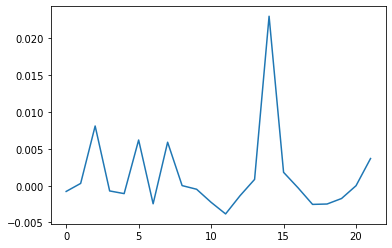

In [144]:
plt.plot(shap_values_100[0])
print(shap_values_100[0].sum()+e.base_values)